# Instructions:
Conduct an EDA and create an interactive notebook in Python or R that can be used as a presentation to explain the findings of
your analysis. It should contain appropriate visualisations and explanations to assist readers in
understanding how these elaborations are arrived at as well as their implications.

# My EDA outline:
### 1) Describe the dataset, examine each characteristic
* df.head()
* df.info()
* df.describe()
* Observations

### 2) Data cleaning
* Weather has strings that have spelling errors, creating unique categories that ought to belong together
* Duplicated rows on datetimes
* Negative values for guest-users and registered-users

### 3) Creating some new columns
* Total users
* Day of week, month

### 4) Some statistics
* distribution of dependent variable (https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/)
* dist plots and box plots of all other variables
* correlation matrix
* Test for multicollinearity

### 5) Feature engineering and selection
* Transforming variables
* Sanity check - correlation matrix + scatter  

### 6) Some concluding words + analysis, finally


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.pyplot as pplt
import seaborn as sns
from pandas.api.types import CategoricalDtype
%matplotlib inline
plt.style.use('seaborn-whitegrid')

### 1) Describe the dataset, examine each characteristic
* df.head()
* df.info()
* df.describe()
* Observations

In [3]:
url = 'https://aisgaiap.blob.core.windows.net/aiap6-assessment-data/scooter_rental_data.csv'
df = pd.read_csv(url)

In [4]:
print(df.head())
print(f"\n\nThe number of observations is {df.shape[0]}, number of characteristics is {df.shape[1]}.")
print(f"The dataset starts from {df['date'].min()} and ends on {df['date'].max()}.")

print(f"\n --------------------------------\n Here are the data types of the given dataset.\n\n")
print(df.info())

         date  hr weather  temperature  feels-like-temperature  \
0  2011-01-01   0   clear         66.7                    95.0   
1  2011-01-01   1   clear         65.0                    93.2   
2  2011-01-01   2   clear         65.0                    93.2   
3  2011-01-01   3   clear         66.7                    95.0   
4  2011-01-01   4   clear         66.7                    95.0   

   relative-humidity  windspeed  psi  guest-users  registered-users  
0               81.0        0.0    3           21               164  
1               80.0        0.0   35           54               417  
2               80.0        0.0   38           35               356  
3               75.0        0.0   35           19               129  
4               75.0        0.0   11           -2                10  


The number of observations is 17958, number of characteristics is 10.
The dataset starts from 2011-01-01 and ends on 2012-12-31.

 --------------------------------
 Here are the dat

In [5]:
df.describe()

,hr,temperature,feels-like-temperature,relative-humidity,windspeed,psi,guest-users,registered-users
count,17958.000000,17958.000000,17958.000000,17958.000000,17958.000000,17958.000000,17958.000000,17958.000000
mean,11.533578,88.457512,117.332008,62.758993,12.733155,24.557300,249.740394,1998.910346
std,6.915319,16.285017,20.416251,19.266532,8.213750,14.451091,344.815252,1966.561546
min,0.000000,48.100000,60.800000,0.000000,0.000000,0.000000,-2.000000,-5.000000
25%,6.000000,75.200000,100.400000,48.000000,7.000000,12.000000,27.000000,441.000000
50%,12.000000,88.700000,118.400000,63.000000,13.000000,24.000000,117.000000,1504.000000
75%,18.000000,102.200000,134.600000,78.000000,17.000000,37.000000,338.000000,2860.000000
max,23.000000,131.000000,179.600000,100.000000,57.000000,49.000000,2567.000000,11519.000000


# Observations
1. No NA values
2. df[hr] seems normal, evenly distributed (25%,50%,75%) - implies no gaps within hours
3. doubtful of df[temperature], as the max recorded was 131°F, and the highest recorded temperature on earth was 134.1°F, in 1913.
4. we should expect that df[feels-like-temperature]-df[temperature] is highly correlated to df[relative-humidity] for higher temperatures, since humidity in the air makes the process of sweating difficult
5. odd that df[guest-users] and df[registered-users] can have negative values, looks like a logging error (when users log out, the counter deducts 1, maybe there was some repeat deductions)

### 2) Data cleaning
* Weather has strings that have spelling errors, creating unique categories that ought to belong together
* Duplicated rows on datetimes
* Negative values for guest-users and registered-users

In [6]:
guest_clean=[]
registered_clean=[]
for i in df['guest-users']:
    if i <0:
        guest_clean.append(0)
    else:
        guest_clean.append(i)
for j in df['registered-users']:
    if j <0:
        registered_clean.append(0)
    else:
        registered_clean.append(j)
df['registered-users']=registered_clean
df['guest-users']=guest_clean

count    17958.000000
mean       249.793518
std        344.776639
min          0.000000
25%         27.000000
50%        117.000000
75%        338.000000
max       2567.000000
Name: guest-users, dtype: float64

I've rewritten all negative values of guest-users and registered-users with 0.


In [7]:
df.weather.value_counts()

clear              11186
cloudy              4492
light snow/rain     1429
lear                 323
CLEAR                288
loudy                111
CLOUDY                95
LIGHT SNOW/RAIN       31
heavy snow/rain        3
Name: weather, dtype: int64

Seems like the weather data is not clean, might need manual mapping.

In [8]:
weather_dict = {'lear':'clear',
                'CLEAR':'clear',
                'loudy':'cloudy',
                'CLOUDY':'cloudy',
                'LIGHT SNOW/RAIN': 'light snow/rain',
               }
weather_clean=[]
for i in df["weather"]:
    if i in weather_dict:
        weather_clean.append(weather_dict[i])
    else:
        weather_clean.append(i)
df["weather"] = weather_clean
print(df.weather.value_counts())

clear              11797
cloudy              4698
light snow/rain     1460
heavy snow/rain        3
Name: weather, dtype: int64


Seems like the weather data is clean now.

In [9]:
df['date_time'] = pd.to_datetime(df['date'] + ' ' + df['hr'].astype(str) + ':00:00')
print(df['date_time'])

0       2011-01-01 00:00:00
1       2011-01-01 01:00:00
2       2011-01-01 02:00:00
3       2011-01-01 03:00:00
4       2011-01-01 04:00:00
                ...        
17953   2011-10-11 12:00:00
17954   2011-04-23 13:00:00
17955   2011-03-14 01:00:00
17956   2012-05-27 22:00:00
17957   2012-04-29 10:00:00
Name: date_time, Length: 17958, dtype: datetime64[ns]


Creating a date+time column since the nature of the data appears to be unique on a day and hour.

In [11]:
print("Duplicate Rows except first occurrence based on ALL columns are :")
duplicateRowsDF = df[df.duplicated(keep='last')]
print(duplicateRowsDF.shape)

print('''------------------

ok, now we check if the duplicates are the same if based on date_time only.

------------------
Duplicate Rows except first occurrence based on date_time are :''')

duplicateRowsDF_one = df[df.duplicated(['date_time'],keep='last')]
print(duplicateRowsDF_one.shape)


df.drop_duplicates(subset ="date_time", keep = 'first', inplace=True)

Duplicate Rows except first occurrence based on all columns are :
(0, 11)
------------------

ok, now we check if the duplicates are the same if based on date_time only.

------------------
Duplicate Rows except first occurrence based on date_time are :
(0, 11)


Since all duplicates on date_time were all the duplicates there were, we assume now that date_time uniquely identifies a row.
Duplicates are dropped and we now have clean data.

In [12]:
df.head()

,date,hr,weather,temperature,feels-like-temperature,relative-humidity,windspeed,psi,guest-users,registered-users,date_time
0,2011-01-01,0,clear,66.7,95.0,81.0,0.0,3,21,164,2011-01-01 00:00:00
1,2011-01-01,1,clear,65.0,93.2,80.0,0.0,35,54,417,2011-01-01 01:00:00
2,2011-01-01,2,clear,65.0,93.2,80.0,0.0,38,35,356,2011-01-01 02:00:00
3,2011-01-01,3,clear,66.7,95.0,75.0,0.0,35,19,129,2011-01-01 03:00:00
4,2011-01-01,4,clear,66.7,95.0,75.0,0.0,11,0,10,2011-01-01 04:00:00


### 3) Creating some new columns
* Total users
* Day of week, month


In [13]:
df['month'] =df['date_time'].dt.month
df['day'] = df['date_time'].dt.weekday_name
df.head()

,date,hr,weather,temperature,feels-like-temperature,relative-humidity,windspeed,psi,guest-users,registered-users,date_time,month,day
0,2011-01-01,0,clear,66.7,95.0,81.0,0.0,3,21,164,2011-01-01 00:00:00,1,Saturday
1,2011-01-01,1,clear,65.0,93.2,80.0,0.0,35,54,417,2011-01-01 01:00:00,1,Saturday
2,2011-01-01,2,clear,65.0,93.2,80.0,0.0,38,35,356,2011-01-01 02:00:00,1,Saturday
3,2011-01-01,3,clear,66.7,95.0,75.0,0.0,35,19,129,2011-01-01 03:00:00,1,Saturday
4,2011-01-01,4,clear,66.7,95.0,75.0,0.0,11,0,10,2011-01-01 04:00:00,1,Saturday


Added month and day columns, for mlp stage, and also to be analyzed later.

In [15]:
df['total-users'] = df["guest-users"] + df["registered-users"]
print(df['total-users'])

I am now adding a new column total-users.
0         185
1         471
2         391
3         148
4          10
         ... 
17374    1481
17375    1106
17376    1130
17377     716
17378     565
Name: total-users, Length: 17379, dtype: int64


Added a new column total-users as the dependent variable of mlp stage.

### 4) Some statistics
* distribution of dependent variable (https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/)
* dist plots and box plots of all other variables
* correlation matrix
* Test for multicollinearity

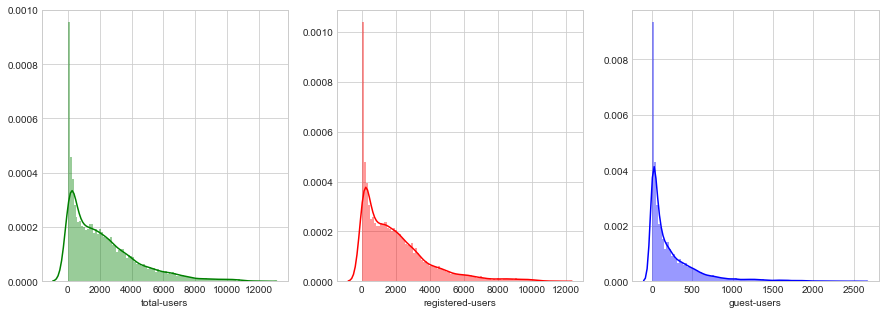

In [16]:
f, axes = plt.subplots(1,3, figsize=(15, 5), sharex=False)

sns.distplot(df['total-users'], color='g', bins=100, hist_kws={'alpha': 0.4}, ax=axes[0])
sns.distplot(df['registered-users'], color='r', bins=100, hist_kws={'alpha': 0.4}, ax=axes[1])
sns.distplot(df['guest-users'], color='b', bins=100, hist_kws={'alpha': 0.4}, ax=axes[2])


Seems like the resultant column df[total-users] resembles registered-users, because it is of higher magnitude than guest-users.
From the dist plot, it seems like df[total-users] has one peak, with a long right tail. Doesn't look normally distributed, so let's check.

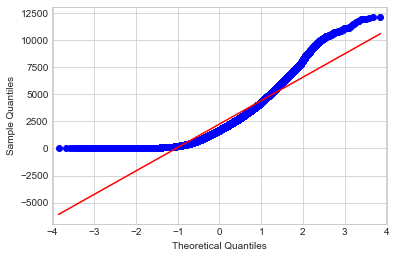

In [17]:
# QQ Plot

from statsmodels.graphics.gofplots import qqplot
data = df['total-users']
# q-q plot
qqplot(data, line='s')
pplt.show()



From the QQ plot it really does not seem like the distribution of total-users is normal.

In [18]:
from scipy.stats import shapiro, normaltest, anderson

data = df['total-users']
alpha = 0.05

print('''Checking normality using Shapiro-Wilk Test... 
-------------------------''')
# normality test using shapiro
stat, p = shapiro(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret

if p > alpha:
	print(f'Sample looks Gaussian at alpha = {alpha} (fail to reject H0). Use Parametric Statistical Methods.')
else:
	print(f'Sample does not look Gaussian at alpha = {alpha} (reject H0). Use Nonparametric Statistical Methods.')
    
print('''

Checking normality using D’Agostino’s K^2 test... 
-------------------------''')
# normality test using D’Agostino’s K^2 test
stat, p = normaltest(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
if p > alpha:
	print(f'Sample looks Gaussian at alpha = {alpha} (fail to reject H0). Use Parametric Statistical Methods.')
else:
	print(f'Sample does not look Gaussian at alpha = {alpha}  (reject H0). Use Nonparametric Statistical Methods.')
    

print(f'''

Checking normality using Anderson Darling test... 
-------------------------''')
# normality test using anderson darling's test
result = anderson(data)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print(f'At {sl} significance level with critical value of {cv}, data looks normal (fail to reject H0). Use Parametric Statistical Methods.')
	else:
		print(f'At {sl} significance level with critical value of {cv}, data does not look normal (reject H0). Use Nonparametric Statistical Methods.')

Checking normality using Shapiro-Wilk Test... 
-------------------------
Statistics=0.868, p=0.000
Sample does not look Gaussian at alpha = 0.05 (reject H0). Use Nonparametric Statistical Methods.


Checking normality using D’Agostino’s K^2 test... 
-------------------------
Statistics=3953.015, p=0.000
Sample does not look Gaussian at alpha = 0.05  (reject H0). Use Nonparametric Statistical Methods.


Checking normality using Anderson Darling test... 
-------------------------
Statistic: 595.738
At 15.0 significance level with critical value of 0.576, data does not look normal (reject H0). Use Nonparametric Statistical Methods.
At 10.0 significance level with critical value of 0.656, data does not look normal (reject H0). Use Nonparametric Statistical Methods.
At 5.0 significance level with critical value of 0.787, data does not look normal (reject H0). Use Nonparametric Statistical Methods.
At 2.5 significance level with critical value of 0.918, data does not look normal (reject H0).

C:\Users\p_chin\.conda\envs\pris_test\lib\site-packages\scipy\stats\morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


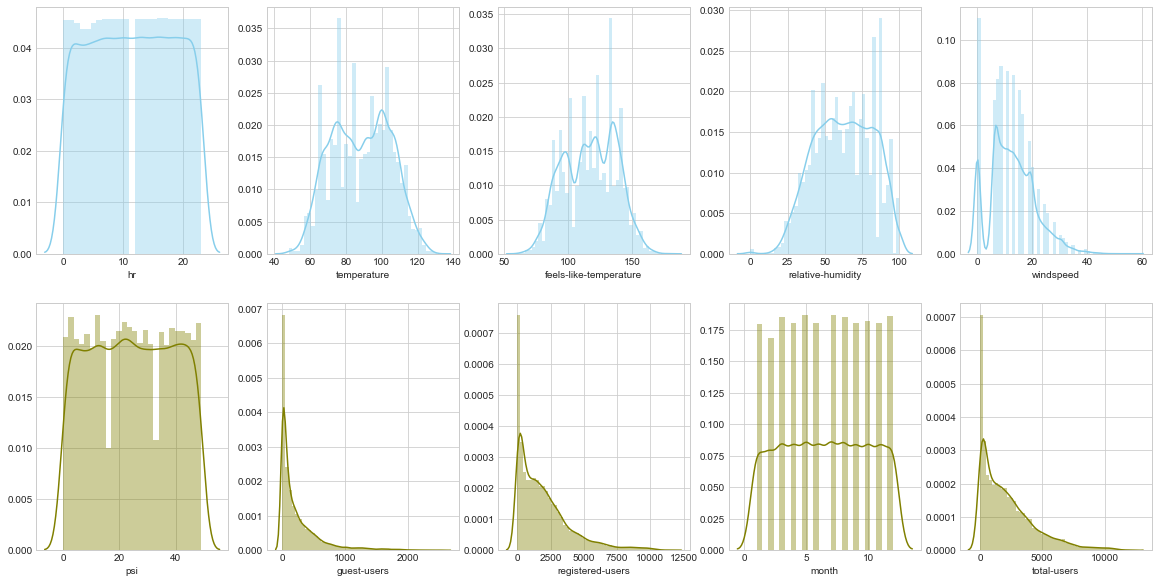

In [23]:
distplot_cols = df.select_dtypes(include = 'number')
distplot_cols.describe()

f, axes = plt.subplots(2, 5, figsize=(20, 10), sharex=False)

sns.distplot( distplot_cols[distplot_cols.columns[0]] , color="skyblue", ax=axes[0, 0])
sns.distplot( distplot_cols[distplot_cols.columns[1]] , color="skyblue", ax=axes[0, 1])
sns.distplot( distplot_cols[distplot_cols.columns[2]] , color="skyblue", ax=axes[0, 2])
sns.distplot( distplot_cols[distplot_cols.columns[3]] , color="skyblue", ax=axes[0, 3])
sns.distplot( distplot_cols[distplot_cols.columns[4]] , color="skyblue", ax=axes[0, 4])


sns.distplot( distplot_cols[distplot_cols.columns[5]] , color="olive", ax=axes[1, 0])
sns.distplot( distplot_cols[distplot_cols.columns[6]] , color="olive", ax=axes[1, 1])
sns.distplot( distplot_cols[distplot_cols.columns[7]] , color="olive", ax=axes[1, 2])
sns.distplot( distplot_cols[distplot_cols.columns[8]] , color="olive", ax=axes[1, 3])
sns.distplot( distplot_cols[distplot_cols.columns[9]] , color="olive", ax=axes[1, 4])


In [75]:
down_cast_int = df.select_dtypes(include = 'integer').columns 
down_cast_float = df.select_dtypes(include = 'float').columns 

print(down_cast_int)
print(down_cast_float)

Index(['hr', 'psi', 'guest-users', 'registered-users', 'month', 'total-users'], dtype='object')
Index(['temperature', 'feels-like-temperature', 'relative-humidity',
       'windspeed', 'temperature_trf', 'feels-like-temperature_trf'],
      dtype='object')


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17379 entries, 0 to 17378
Data columns (total 16 columns):
date                          17379 non-null object
hr                            17379 non-null int64
weather                       17379 non-null object
temperature                   17379 non-null float64
feels-like-temperature        17379 non-null float64
relative-humidity             17379 non-null float64
windspeed                     17379 non-null float64
psi                           17379 non-null int64
guest-users                   17379 non-null int64
registered-users              17379 non-null int64
date_time                     17379 non-null datetime64[ns]
month                         17379 non-null int64
day                           17379 non-null category
total-users                   17379 non-null int64
temperature_trf               17379 non-null float64
feels-like-temperature_trf    17379 non-null float64
dtypes: category(1), datetime64[ns](1), float64(6


##### features with uniform distribution:
* hr, month, which is to be expected since the data is collected consistently every hour, every day.
* psi appears to be uniformly distributed, which is weird.

##### features with normal distribution:
* relative-humidity looks pretty normal
* temperature, feels-like-temperature have multiple peaks but are approximately normally distributed, but we'll explore that later.
* windspeed

<Figure size 432x288 with 0 Axes>

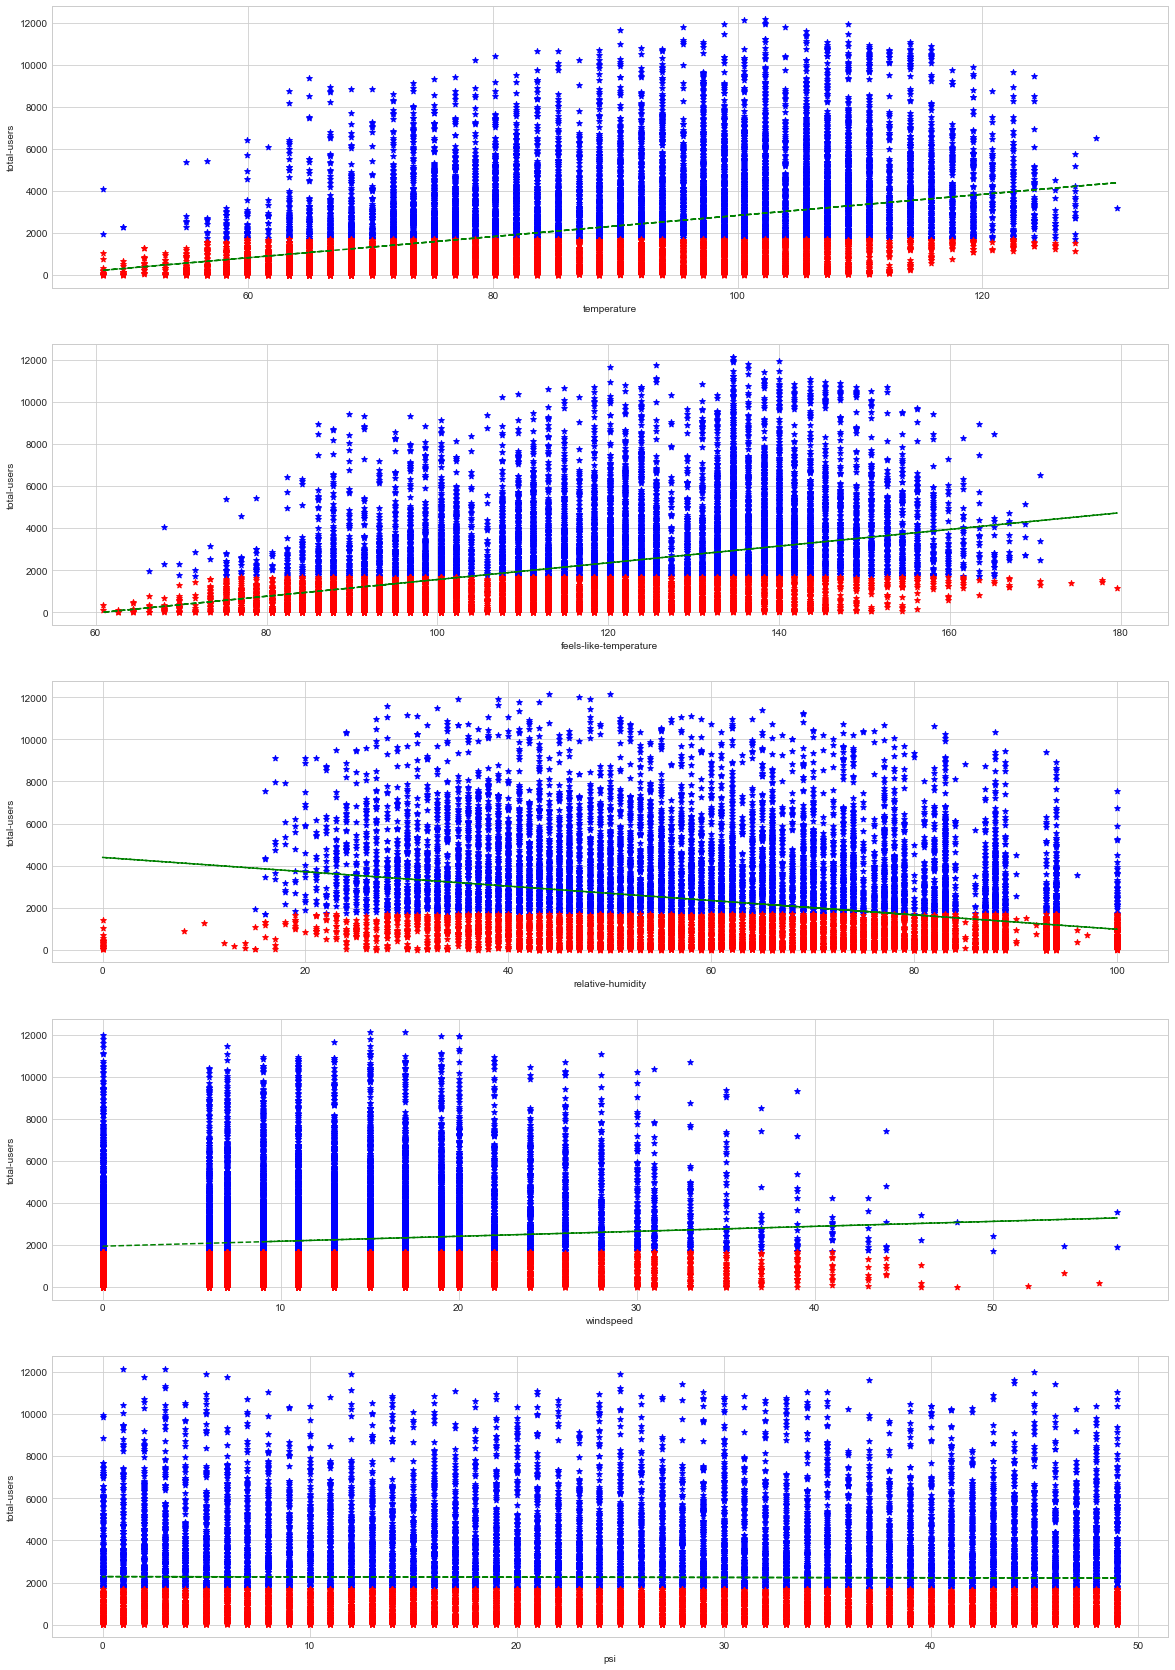

In [56]:
selected_features = ["temperature", "feels-like-temperature"
                     , "relative-humidity", "windspeed", "psi"]
select_y = "total-users"

above_median = (df['total-users']>df['total-users'].median()) 
below_median = (df['total-users']<=df['total-users'].median()) 
df_above_median = df[above_median]
df_below_median = df[below_median]

f = plt.figure()    
f, axes = plt.subplots(nrows = len(selected_features), ncols = 1, figsize=(20, 30), sharex=False, sharey = True)

for i, x in enumerate(selected_features):
    color='b'
    color_below='r'
    axes[i].scatter(df_above_median[x],df_above_median[select_y], c = color, marker = "*")
    axes[i].scatter(df_below_median[x],df_below_median[select_y], c = color_below, marker = "*")
    axes[i].set_xlabel(x)
    axes[i].set_ylabel(select_y)
    z = np.polyfit(df[x], df[select_y], 1)
    p = np.poly1d(z)
    axes[i].plot(df[x],p(df[x]),"g--")

plt.show()

I plotted the total-users against each continuous variable, with red scatters representing totals-users below median. As we can tell, total-users has a very long tail.

##### temperature, feels-like-temperature
- temperature & feels-like-temperature have similar relationships with total-users.
- have quadratic relationship, might need to transform, and choose variable with better predictive ability
- for now, I will linear-ise the relationship by centre-ing the max of distribution at x=0, and squaring x. 

##### relative-humidity
- has decreasing linear relationship with total-users

##### windspeed
- has a weaker linear relationship with total-users, generally increasing with windspeed

#### psi
- seems useless, looks like it has no predictive ability for now. will decide at feature selection stage.


### 5) Feature engineering and selection
* Transforming variables
* Sanity check - correlation matrix + scatter  


<Figure size 432x288 with 0 Axes>

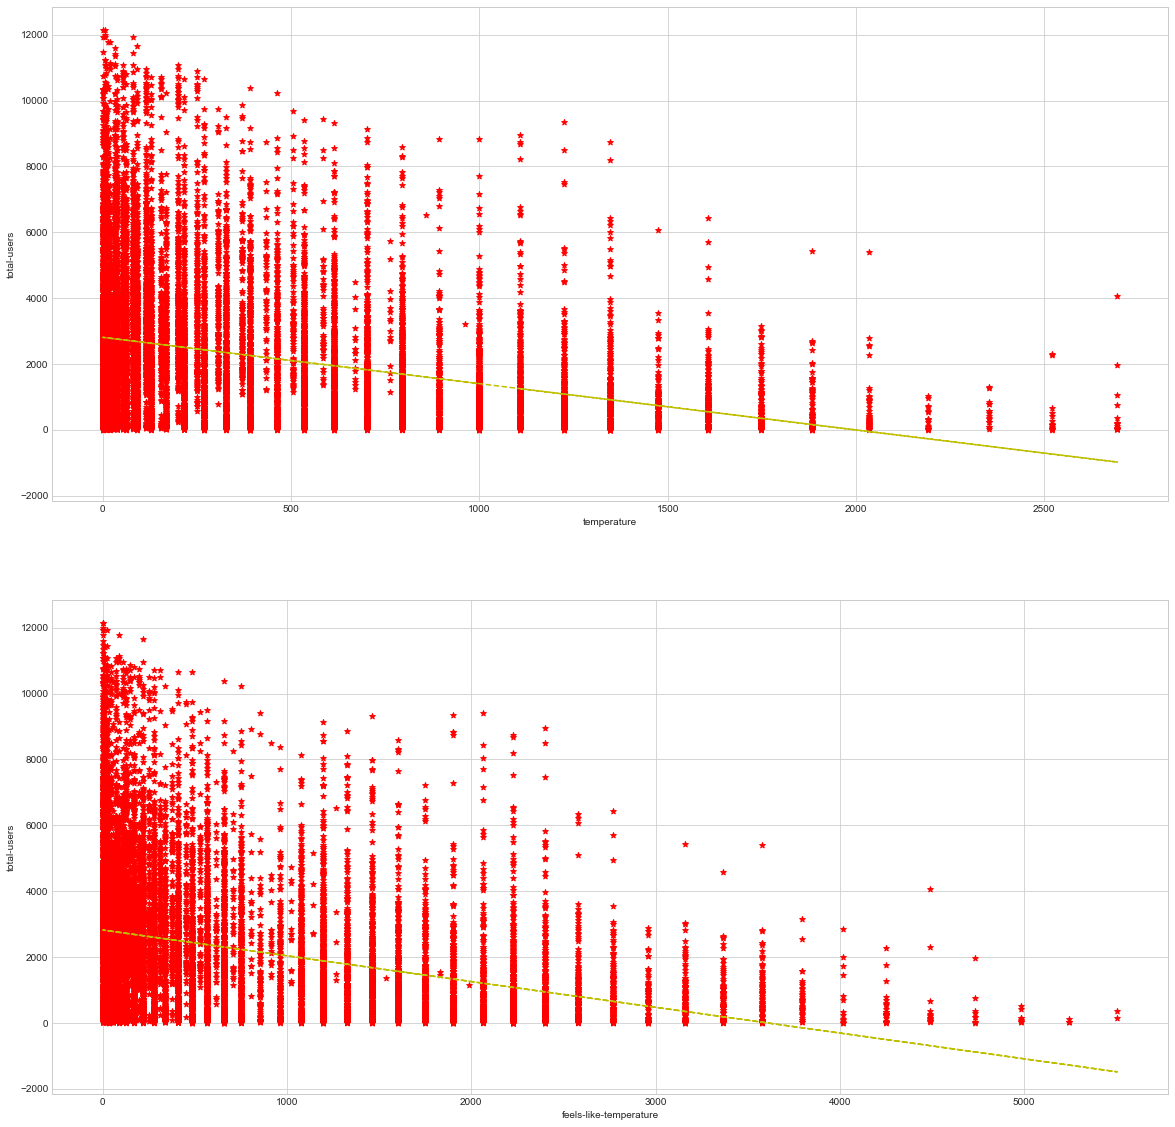

In [60]:
selected_features = ["temperature", "feels-like-temperature"]
x_max_value = [100,135]
select_y = "total-users"

f = plt.figure()    
f, axes = plt.subplots(nrows = len(selected_features), ncols = 1, figsize=(20, 20), sharex=False, sharey = True)

for i, x in enumerate(selected_features):
    x_plot= []
    for xx in df[x]:
        x_plot.append((xx - x_max_value[i])**2)
    
    color='r'
    axes[i].scatter(x_plot,df[select_y], c = color_below, marker = "*")
    axes[i].set_xlabel(x)
    axes[i].set_ylabel(select_y)
    z = np.polyfit(x_plot, df[select_y], 1)
    p = np.poly1d(z)
    axes[i].plot(x_plot,p(x_plot),"y--")

plt.show()


For now the transformation looks alright, so I shall create 2 additional features for temperature and feels-like-temperature and look at the correlation matrix .

In [61]:
temperature_trf=[]
feels_like_temperature_trf=[]
for i in df["temperature"]:
    temperature_trf.append((i - 100)**2)
for j in df["feels-like-temperature"]:
    feels_like_temperature_trf.append((j - 135)**2)
df["temperature_trf"]=temperature_trf
df["feels-like-temperature_trf"]=feels_like_temperature_trf
df.describe()

,hr,temperature,feels-like-temperature,relative-humidity,windspeed,psi,guest-users,registered-users,month,total-users,temperature_trf,feels-like-temperature_trf
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,11.546752,88.445624,117.322009,62.722884,12.736233,24.537488,249.793026,1999.218482,6.537775,2249.011508,398.855886,729.273682
std,6.914405,16.290106,20.415345,19.292983,8.196891,14.457358,345.079978,1967.662087,3.438776,2163.012388,466.385285,880.915592
min,0.000000,48.100000,60.800000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,5.000000,0.250000,0.160000
25%,6.000000,75.200000,100.400000,48.000000,7.000000,12.000000,27.000000,442.500000,4.000000,485.000000,38.440000,57.760000
50%,12.000000,88.700000,118.400000,63.000000,13.000000,24.000000,117.000000,1500.000000,7.000000,1696.000000,216.090000,338.560000
75%,18.000000,102.200000,134.600000,78.000000,17.000000,37.000000,338.000000,2859.000000,10.000000,3305.500000,615.040000,1197.160000
max,23.000000,131.000000,179.600000,100.000000,57.000000,49.000000,2567.000000,11519.000000,12.000000,12154.000000,2693.610000,5505.640000


In [64]:
corr = df.corr()
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '8pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,hr,temperature,feels-like-temperature,relative-humidity,windspeed,psi,guest-users,registered-users,month,total-users,temperature_trf,feels-like-temperature_trf
hr,1,0.14,0.13,-0.28,0.14,-0.0059,0.3,0.37,-0.0058,0.39,-0.091,-0.092
temperature,0.14,1,0.99,-0.07,-0.023,-0.0052,0.46,0.34,0.2,0.38,-0.81,-0.84
feels-like-temperature,0.13,0.99,1,-0.052,-0.062,-0.0046,0.45,0.33,0.21,0.37,-0.82,-0.86
relative-humidity,-0.28,-0.07,-0.052,1,-0.29,0.00069,-0.35,-0.27,0.16,-0.3,-0.095,-0.085
windspeed,0.14,-0.023,-0.062,-0.29,1,0.0053,0.09,0.082,-0.14,0.089,0.028,0.11
psi,-0.0059,-0.0052,-0.0046,0.00069,0.0053,1,0.0041,-0.011,-0.003,-0.009,0.0019,0.0025
guest-users,0.3,0.46,0.45,-0.35,0.09,0.0041,1,0.51,0.068,0.62,-0.34,-0.36
registered-users,0.37,0.34,0.33,-0.27,0.082,-0.011,0.51,1,0.12,0.99,-0.27,-0.29
month,-0.0058,0.2,0.21,0.16,-0.14,-0.003,0.068,0.12,1,0.12,-0.28,-0.28
total-users,0.39,0.38,0.37,-0.3,0.089,-0.009,0.62,0.99,0.12,1,-0.3,-0.32


#### Observations:
- Unsurprisingly, temperature is highly correlated with feels-like-temperature. Will need to choose between the two during modelling.
- Although the magnitude of correlation of the two transformed variables are smaller, the relationship was more linear (from the scatterplot), so I will probably stick to it
-  psi has a very low correlation to total-users. 

### 6) Analysis, finally

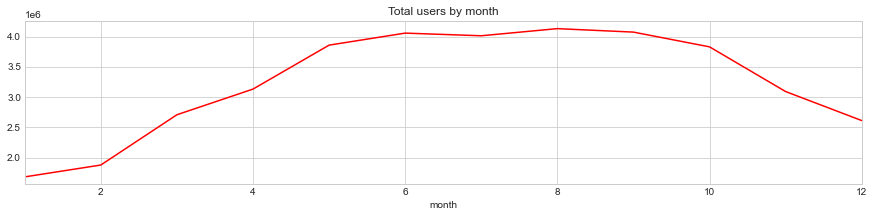

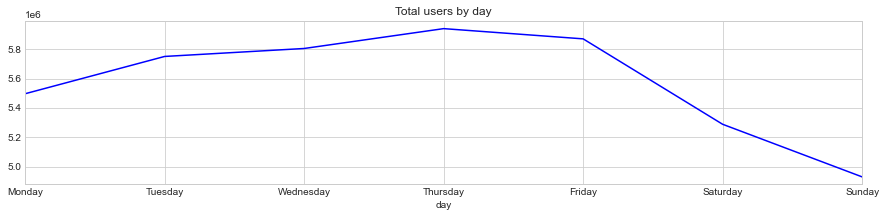

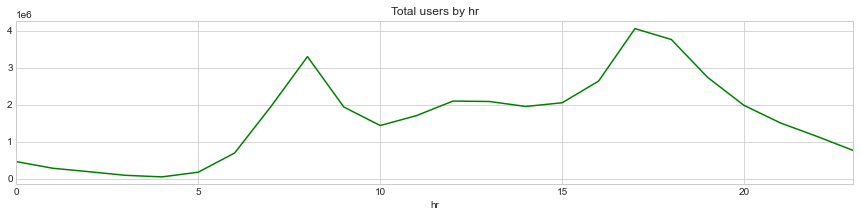

In [68]:
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day'] = pd.Categorical(df['day'], categories=cats, ordered=True)

def plot_totalusers(time, plot_color):
    df.groupby(time)['total-users'].agg('sum').plot(figsize = (15,3),
         title = "Total users by {}".format(time),
         color = plot_color)
    plt.show()

plot_totalusers('month', 'r')
plot_totalusers('day', 'b')
plot_totalusers('hr', 'g')

#### total-users by month
It's apparent that the peak seasons are non-holiday months, where the total-users swell in the middle of the year.

#### total-users by day of week
Seems that the demand for rental scooters are highest on weekdays, implying that the demand stems from working professionals. 

#### total-users by hour
We see two clear peaks: 8am and 6pm, which are commute hours. This reinforces my hypothesis that the core demand stems from working professionals.

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

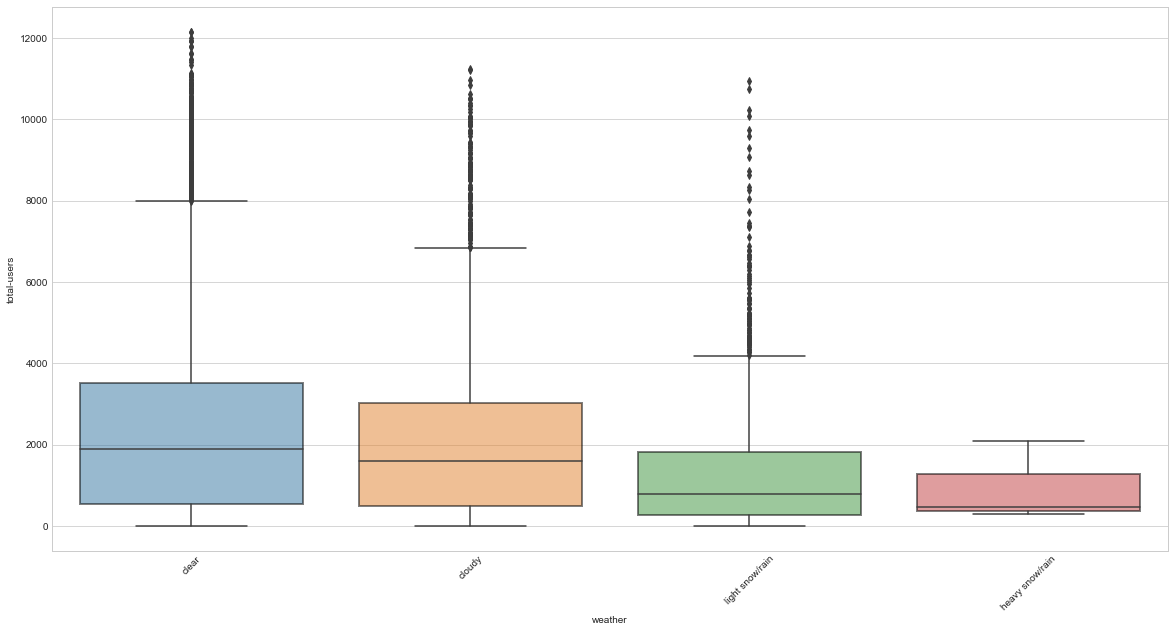

In [69]:
plt.figure(figsize = (20, 10))
ax = sns.boxplot(x='weather', y='total-users', data=df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

Because the variance of total-users is so large, I had to force all min and max values to be considered.

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

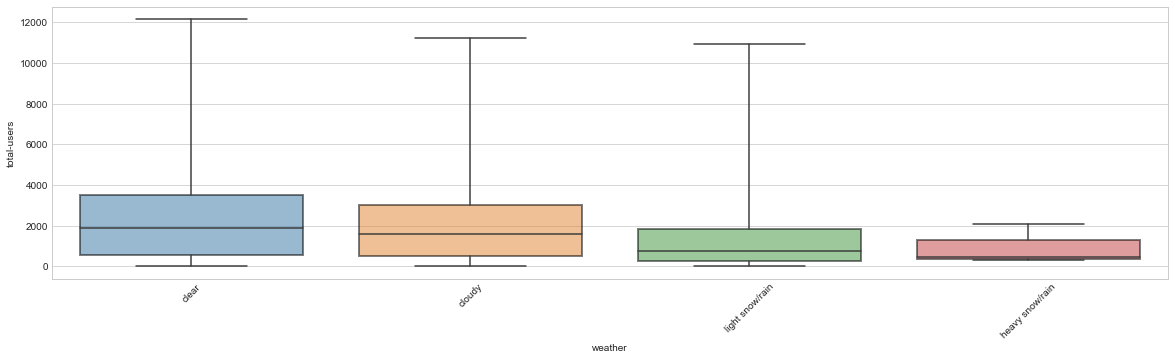

In [72]:
plt.figure(figsize = (20, 5))
ax = sns.boxplot(x='weather', y='total-users', data=df, whis=[0,100])
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

Unsurprisingly, we see that the highest demand for scooters are in clear weathers. Seems like this would be a good feature to include at the modelling stage.